<a href="https://colab.research.google.com/github/aya-bani/sgmd-number-neurons/blob/main/sgmd_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test multiple hidden-layer setups (1, 2, 3, or 4 hidden layers with different neurons).

Pick the “best” configuration based on the lowest validation MSE.

Compare activation functions

Take that best architecture and re-train it using sigmoid, tanh, and ReLU activations.

Compare which activation function gives the best overall metrics (MSE, MAE, R²).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np, pandas as pd, tensorflow as tf, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


In [ ]:
def set_seeds(seed=42):
    np.random.seed(seed); random.seed(seed); tf.random.set_seed(seed)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/projet mit/data.csv", encoding="latin1")
X = data[["Tf_in","Ua","Uw"]].values
y = data["Y"].values.reshape(-1,1)

scaler_X = MinMaxScaler()
Xs = scaler_X.fit_transform(X)

In [ ]:
scaler_y = MinMaxScaler(feature_range=(0.2, 0.8))
ys = scaler_y.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(Xs, ys, test_size=0.30, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [ ]:
def build_model(layers, hidden_act="sigmoid", out_act="sigmoid"):
    """
    layers: list of neuron counts, e.g. [12,8] = 2 hidden layers
    hidden_act: activation for hidden layers
    out_act: activation for output (sigmoid since Y in [0.2,0.8])
    """
    model = Sequential()
    # First hidden layer
    model.add(Dense(layers[0], input_dim=3, activation=hidden_act))
    # Additional hidden layers
    for n in layers[1:]:
        model.add(Dense(n, activation=hidden_act))
    # Output layer (1 neuron, regression)
    model.add(Dense(1, activation=out_act))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
def evaluate_model(model, X, y):
    """Return MSE, MAE, R² in original Y units."""
    y_pred = model.predict(X, verbose=0)
    y_true = scaler_y.inverse_transform(y)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    return (
        mean_squared_error(y_true, y_pred_inv),
        mean_absolute_error(y_true, y_pred_inv),
        r2_score(y_true, y_pred_inv)
    )

In [ ]:
def sweep_layers(layer_grid, hidden_act="sigmoid"):
    results = []
    for layers in layer_grid:
        set_seeds(42); K.clear_session()
        model = build_model(layers, hidden_act=hidden_act)

        es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        hist = model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=1000, batch_size=8, verbose=0,
                         callbacks=[es])

        # Metrics
        tr = evaluate_model(model, X_train, y_train)
        va = evaluate_model(model, X_val,   y_val)
        te = evaluate_model(model, X_test,  y_test)

        results.append({
            "layers": layers,
            "hidden_act": hidden_act,
            "train_mse": tr[0], "train_mae": tr[1], "train_r2": tr[2],
            "val_mse": va[0],   "val_mae": va[1],   "val_r2": va[2],
            "test_mse": te[0],  "test_mae": te[1],  "test_r2": te[2],
            "epochs_used": len(hist.history['loss'])
        })
    return pd.DataFrame(results)

8;df1 = sweep_layers(grid_1, hidden_act="sigmoid")
df2 = sweep_layers(grid_2, hidden_act="sigmoid")
df3 = sweep_layers(grid_3, hidden_act="sigmoid")
df4 = sweep_layers(grid_4, hidden_act="sigmoid")

all_df = pd.concat([df1,df2,df3,df4], ignore_index=True)

In [ ]:
# 7. Define search grids
# ============================
grid_1 = [[n] for n in range(5, 21, 3)]                 # 1 hidden layer
grid_2 = [[n1,n2] for n1 in [20,15,10] for n2 in [15,10,5]]
grid_3 = [[15,10,5], [12,8,6], [20,15,10]]
grid_4 = [[20,15,10,5], [15,12,8,5]]

# ============================
# 8. Run sweeps (sigmoid hidden as baseline)
# ============================

df1 = sweep_layers(grid_1, hidden_act="sigmoid")
df2 = sweep_layers(grid_2, hidden_act="sigmoid")
df3 = sweep_layers(grid_3, hidden_act="sigmoid")
df4 = sweep_layers(grid_4, hidden_act="sigmoid")

all_df = pd.concat([df1,df2,df3,df4], ignore_index=True)

# Find best config by lowest val MSE
best_row = all_df.loc[all_df["val_mse"].idxmin()]
print("\n=== Best architecture (hidden layers + neurons) ===")
print(best_row[["layers","hidden_act","val_mse","val_mae","val_r2","test_mse","test_mae","test_r2"]])




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo


=== Best architecture (hidden layers + neurons) ===
layers         [10, 5]
hidden_act     sigmoid
val_mse       0.012836
val_mae       0.075279
val_r2        0.562207
test_mse      0.003474
test_mae      0.049921
test_r2        0.88916
Name: 14, dtype: object



Best number of neurons for 1 hidden layer = 11, Validation MSE = 0.02526


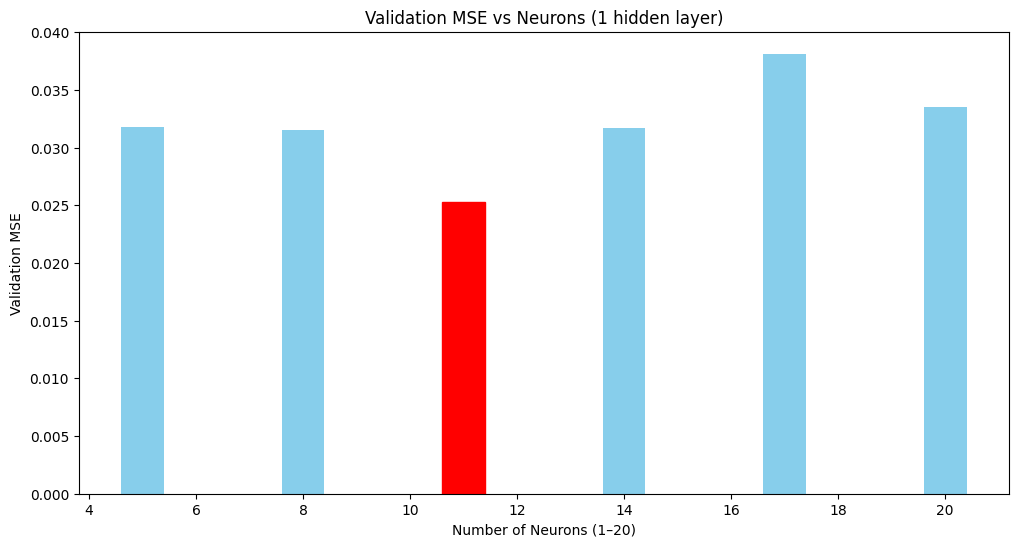

In [ ]:
# 8b. Plot validation MSE vs neurons for 1 hidden layer
# ============================
import matplotlib.pyplot as plt # Import matplotlib

res_df_sorted = df1.sort_values("layers")  # only 1-layer models
min_idx = res_df_sorted["val_mse"].idxmin()
min_neurons = res_df_sorted.loc[min_idx, "layers"][0]
min_val_mse = res_df_sorted.loc[min_idx, "val_mse"]

print(f"\nBest number of neurons for 1 hidden layer = {min_neurons}, Validation MSE = {min_val_mse:.5f}")

plt.figure(figsize=(12,6))
bars = plt.bar([l[0] for l in res_df_sorted["layers"]], res_df_sorted["val_mse"], color="skyblue")
bars[list(res_df_sorted.index).index(min_idx)].set_color("red")
plt.xlabel("Number of Neurons (1–20)")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs Neurons (1 hidden layer)")
plt.show()

In [ ]:
best_layers = best_row["layers"]
act_results = []
for act in ["sigmoid","tanh","relu"]:
    df_act = sweep_layers([best_layers], hidden_act=act)
    act_results.append(df_act.iloc[0])

act_df = pd.DataFrame(act_results)
print("\n=== Activation comparison on best architecture ===")
print(act_df[["hidden_act","val_mse","val_mae","val_r2","test_mse","test_mae","test_r2"]])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== Activation comparison on best architecture ===
  hidden_act   val_mse   val_mae    val_r2  test_mse  test_mae   test_r2
0    sigmoid  0.012836  0.075279  0.562207  0.003474  0.049921  0.889160
0       tanh  0.010016  0.068331  0.658411  0.004834  0.060307  0.845768
0       relu  0.012494  0.073619  0.573877  0.011113  0.098212  0.645416


In [ ]:
best_row = all_df.loc[all_df["val_mse"].idxmin()]
print("\n=== Best architecture ===")
print(best_row[["layers","hidden_act","val_mse","val_mae","val_r2","test_mse","test_mae","test_r2"]])



=== Best architecture ===
layers         [10, 5]
hidden_act     sigmoid
val_mse       0.012836
val_mae       0.075279
val_r2        0.562207
test_mse      0.003474
test_mae      0.049921
test_r2        0.88916
Name: 14, dtype: object


best_layers = best_row["layers"]
act_results = []
for act in ["sigmoid","tanh","relu"]:
    df_act = sweep_layers([best_layers], hidden_act=act)
    act_results.append(df_act.iloc[0])

act_df = pd.DataFrame(act_results)
print("\n=== Activation comparison on best architecture ===")
print(act_df[["hidden_act","val_mse","val_mae","val_r2","test_mse","test_mae","test_r2"]])


“After testing multiple architectures (1–4 hidden layers, different neuron counts), the configuration with 2 hidden layers [10,5] achieved the lowest validation MSE and the highest test R² (0.889). This indicates that the network can generalize well, so this architecture is chosen as the final model for SGMD prediction.”